# Utils

### Libraries

In [83]:
import pandas as pd
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
import umap
import statsmodels.api as sm
import warnings
import sys
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.optimize import linear_sum_assignment
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
import scikit_posthocs as sp

In [84]:
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("/Users/emmatosato/Documents/PhD/ANM_Verona/src/data_processing")

In [85]:
import importlib
from data_processing import umap_clustering, umap_regression, clustering_evaluation, umap_run, processing_flat

importlib.reload(clustering_evaluation)
importlib.reload(umap_regression)
importlib.reload(umap_clustering)
importlib.reload(umap_run)
importlib.reload(processing_flat)

from data_processing.clustering_evaluation import evaluate_kmeans, evaluate_gmm, evaluate_hdbscan, evaluate_consensus
from data_processing.umap_regression import main_regression, plot_ols_diagnostics, remove_missing_values, plot_actual_vs_predicted
from data_processing.umap_clustering import plot_clusters_vs_groups
from data_processing.umap_run import x_features_return, run_umap

In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Paths and folders

In [54]:
# FC maps directories
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps_processed = '/data/FCmaps_augmented_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"

# Path to masks
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/mask_GM.nii'

# Metadata
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/atrophy_matched.xlsx'
cognitive_dataset ='/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/cognitive_dataset.xlsx'
path_df_meta = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/meta/df_meta.csv"

# Done dataframe of preprocessed FC maps
path_df_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_gm.pkl"
path_df_thr02_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_thr02_gm.pkl"

# Data

## Raw data

#### One file example

In [55]:
# Load an image
path_temp = os.path.join(dir_FCmaps, '1_S_5005.FDC.nii.gz')
img = nib.load(path_temp)

# Separate the data and affine
temp_img = img.get_fdata()      # 3D volume data
temp_affine = img.affine        # 4x4 affine matrix

# Print shapes
print(temp_img.shape)
print(temp_affine.shape)

(91, 109, 91)
(4, 4)


#### Load data

Function for listing the data in nii.gz format and extract the subjects identifiers + printing some infos

In [56]:
def listData_saveID(dir):
    # All nii.gz files in the directory
    files_path = sorted(glob.glob(os.path.join(dir, '*gz')))

    # Extract Subject IDs from filenames
    subject_id = [os.path.basename(f).replace('.FDC.nii.gz', '') for f in files_path]

    # Sanity checks
    assert len(files_path) == len(subject_id), (
        f"Mismatch count: {len(files_path)} files vs {len(subject_id)} IDs"
    )
    assert len(subject_id) == len(set(subject_id)), "ID duplicated"
    for fp, sid in zip(files_path, subject_id):
        fname = os.path.basename(fp)
        expected = sid + '.FDC.nii.gz'
        assert fname == expected, (
            f"Filename “{fname}” do not correspond to the extracted ID“{sid}”"
        )

    print("Check length:")
    print("Files: ", len(files_path))
    print("Subject: ", len(subject_id))

    return files_path, subject_id

In [57]:
files, sub_id = listData_saveID(dir_FCmaps)

Check length:
Files:  176
Subject:  176


In [58]:
maps_FDC = []
for path in files:
    print(path)
    data = nib.load(path).get_fdata().flatten()
    maps_FDC.append(data)

# Stores subjects as rows and voxels as columns
df=pd.DataFrame(maps_FDC)

/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_4654.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_6695.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6264.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6268.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6432.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6479.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6606.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6252.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6682.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/007_S_6341.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_4893.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_6303.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/012_S_4188.FDC.nii.gz

In [59]:
# Copy without id
df_eda = df.copy()

In [60]:
# Insert subjects id
df.insert(0, 'ID', sub_id)
print("\n", df.shape, "\n")


 (176, 902630) 



Some asserts

In [61]:
# 1Ensure the EDA copy has one row per file
assert df_eda.shape[0] == len(files), (
    f"Rows in df_eda ({df_eda.shape[0]}) != number of files ({len(files)})"
)

# Ensure the df has one row per subject ID
assert df.shape[0] == len(sub_id), (
    f"Number of rows ({df.shape[0]}) != number of IDs ({len(sub_id)})"
)

# Verify the ID column matches the original sub_id order exactly
assert df['ID'].tolist() == sub_id, "Row IDs do not match the original sub_id order"

# Confirm there are no duplicate IDs
assert df['ID'].is_unique, "There are duplicate IDs in the DataFrame"

# Check that inserting the ID column did not alter the numeric data
numeric_equal = (df.drop('ID', axis=1).values == df_eda.values).all()
assert numeric_equal, "Numeric data was altered when inserting the ID column"

#### EDA

In [62]:
print(f"Shape of the dataframes: {df_eda.shape}")

Shape of the dataframes: (176, 902629)


In [63]:
# Global Statistics
all_voxels = df_eda.values.flatten()
all_voxels = all_voxels[~np.isnan(all_voxels)]

# Descriptive statistics
stats_summary = {
    "Min": np.min(all_voxels),
    "Max": np.max(all_voxels),
    "Mean": np.mean(all_voxels),
    "Std": np.std(all_voxels),
    "1st Percentile": np.percentile(all_voxels, 1),
    "25th Percentile": np.percentile(all_voxels, 25),
    "Median (50th)": np.percentile(all_voxels, 50),
    "75th Percentile": np.percentile(all_voxels, 75),
    "99th Percentile": np.percentile(all_voxels, 99),
}

df_stats = pd.DataFrame.from_dict(stats_summary, orient='index', columns=['Value'])
print(df_stats)

                    Value
Min             -0.549580
Max              1.618776
Mean             0.021996
Std              0.056745
1st Percentile  -0.013393
25th Percentile  0.000000
Median (50th)    0.000000
75th Percentile  0.008759
99th Percentile  0.269354


## Metadata

Dataset containing:
- ID of the subject
- The diagnosis (Group)
- Sex
- Age
- Education

The regressors:
- CDR_SB: disease gravity with a larger range
- CDR: same but smaller range

In [64]:
# Load the metadata and align to FC map order
df_meta = pd.read_excel(cognitive_dataset, sheet_name='Sheet1')
df_meta['Age'] = df_meta['Age'].round(1)

In [65]:
df_meta.head(5)

,ID,Group,Sex,Age,Education,CDR_SB,MMSE
0,002_S_4654,ADNI,F,80.4,18,1.5,27.0
1,002_S_6695,ADNI,M,66.3,18,4.5,25.0
2,003_S_6264,ADNI,M,58.3,12,2.5,23.0
3,003_S_6268,ADNI,M,71.6,20,0.5,29.0
4,003_S_6432,ADNI,F,67.3,18,0.5,30.0


#### EDA on Labels

In [66]:
print("Meta dataset BEFORE removing a subject")
print(df_meta.shape)

# Remove the subject with ID "4_S_5003"
df_meta = df_meta[df_meta['ID'] != '4_S_5003'].reset_index(drop=True)

print("Meta dataset AFTER removing a subject")
print(df_meta.shape)

Meta dataset BEFORE removing a subject
(177, 7)
Meta dataset AFTER removing a subject
(176, 7)


In [67]:
# Saving the new csv
df_meta.to_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/labels.csv", index=False)

General info

In [68]:
print(df_meta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         176 non-null    object 
 1   Group      176 non-null    object 
 2   Sex        176 non-null    object 
 3   Age        176 non-null    float64
 4   Education  176 non-null    int64  
 5   CDR_SB     171 non-null    float64
 6   MMSE       168 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 9.8+ KB
None


Missing values

In [69]:
print("\nMissing values for column:")
print(df_meta.isna().sum())


Missing values for column:
ID           0
Group        0
Sex          0
Age          0
Education    0
CDR_SB       5
MMSE         8
dtype: int64


Unique values WITH NaN

In [70]:
print("\nUnique Values:")
print("Group:", sorted(df_meta['Group'].unique()))
print("CDR_SB:", np.sort(df_meta['CDR_SB'].unique()))
print("MMSE:", np.sort(df_meta['MMSE'].unique()))


Unique Values:
Group: ['ADNI', 'CBS', 'PSP']
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18.   nan]
MMSE: [ 4.  5.  8.  9. 10. 11. 12. 14. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30. nan]


Unique values WITHOUT NaN

In [71]:
cdr_sb_no_nan = df_meta['CDR_SB'].dropna()
mmse_no_nan = df_meta['MMSE'].dropna()

In [72]:
print("\nUnique Values:")
print("CDR_SB:", np.sort(cdr_sb_no_nan.unique()))
print("MMSE:", np.sort(mmse_no_nan.unique()))


Unique Values:
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18. ]
MMSE: [ 4.  5.  8.  9. 10. 11. 12. 14. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30.]


In [73]:
print(df_meta.select_dtypes(include='number').describe().round(1))

         Age  Education  CDR_SB   MMSE
count  176.0      176.0   171.0  168.0
mean    70.9       15.8     4.1   24.1
std      8.4        3.5     3.4    5.0
min     53.0        2.0     0.0    4.0
25%     64.0       14.0     1.5   22.0
50%     71.2       16.0     3.5   25.0
75%     76.0       18.0     6.0   28.0
max     93.8       27.0    18.0   30.0


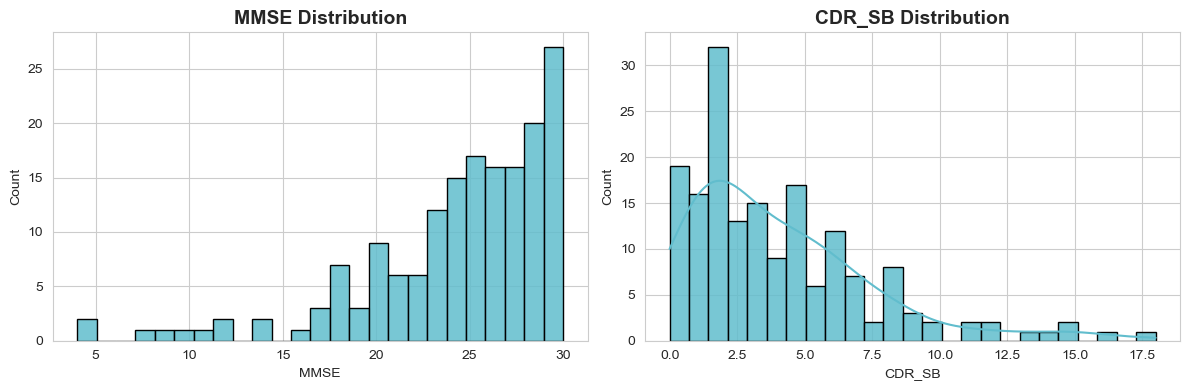

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(mmse_no_nan, bins=25, ax=axes[0], color='#61bdcd', edgecolor='black', alpha=0.85)
axes[0].set_title("MMSE Distribution", fontsize=14, weight='bold')

sns.histplot(cdr_sb_no_nan, bins=25, ax=axes[1], color='#61bdcd', edgecolor='black', alpha=0.85, kde=True)
axes[1].set_title("CDR_SB Distribution", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

#### GMM on CDR_SB

- Assigning each CDB_SB value to a cluster using GMM, removing NaN values before
- New column for the metadata dataframe

In [75]:
# Filter valid CDR_SB values
df_cdr = df_meta[['ID', 'CDR_SB']].dropna().copy()
print("Dimensions after dropping NaN", df_cdr.shape)

# Fit GMM and predict raw labels
np.random.seed(42)
x_gmm = df_cdr['CDR_SB'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=3, random_state=42).fit(x_gmm)
df_cdr['GMM_Label'] = gmm.predict(x_gmm)

# Reorder labels by CDR_SB severity
means = df_cdr.groupby('GMM_Label')['CDR_SB'].mean().sort_values()
label_map = {old: new for new, old in enumerate(means.index)}
df_cdr['GMM_Label'] = df_cdr['GMM_Label'].map(label_map)

# Include in metadata
label_map = dict(zip(df_cdr['ID'], df_cdr['GMM_Label']))
df_meta = df_meta.drop(columns=['GMM_Label'], errors='ignore')
df_meta['GMM_Label'] = df_meta['ID'].map(label_map).astype('Int64')

Dimensions after dropping NaN (171, 2)


In [76]:
print(df_meta['GMM_Label'].value_counts().sort_index())

GMM_Label
0    80
1    76
2    15
Name: count, dtype: Int64


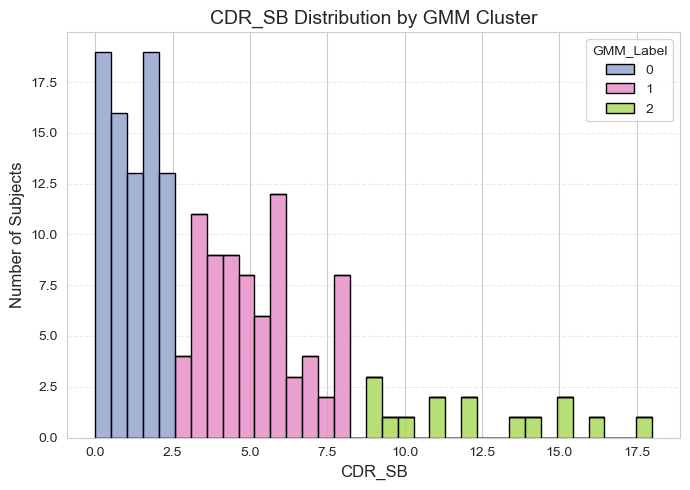

In [80]:
plt.figure(figsize=(7, 5))

set_2 = sns.color_palette("Set2")[2:]

sns.histplot(
    data=df_meta.dropna(subset=['CDR_SB', 'GMM_Label']),
    x='CDR_SB',
    hue='GMM_Label',
    palette=set_2,
    multiple='stack',   # oppure 'dodge' per barre affiancate
    bins=35,
    edgecolor='black',
    alpha=0.8
)

plt.xlabel("CDR_SB", fontsize=12)
plt.ylabel("Number of Subjects", fontsize=12)
plt.title("CDR_SB Distribution by GMM Cluster", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

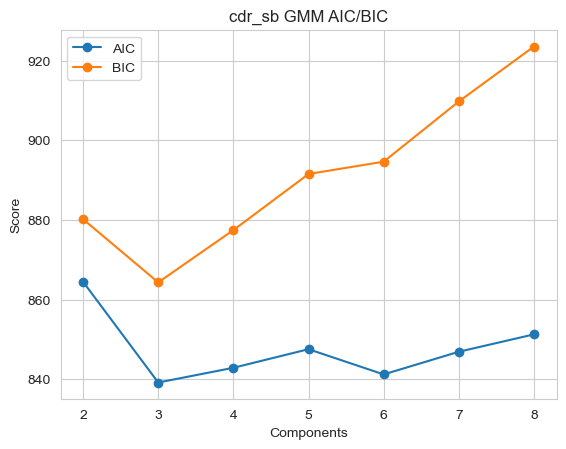

In [82]:
aic, bic = evaluate_gmm(x_gmm, K_range=range(2, 9), save_path= None, prefix="cdr_sb", plot_flag=True)

## Yeo Data

In [ ]:
df_networks_no_thr = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_noTHR.csv")
df_networks_thr01 = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_thr01.csv")
df_networks_thr02 = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_thr02.csv")

In [ ]:
df_networks_no_thr = df_networks_no_thr.rename(columns={"CODE": "ID"})
df_networks_thr01 = df_networks_thr01.rename(columns={"CODE": "ID"})
df_networks_thr02 = df_networks_thr02.rename(columns={"CODE": "ID"})

In [ ]:
features_network = ['VIS_mean', 'VAN_mean', 'DAN_mean', 'DMN_mean', 'LMB_mean', 'FPN_mean', 'SMN_mean', 'SUBCORTICAL_mean']

# Analysis with UMAP

## Data

### Load data

Recall the dataframe with ID and values of the maps

In [ ]:
print("\n", df.shape, "\n")
df.iloc[:5, :5]

Merging the meta columns with the above dataframe: the order of the subject must be the same of the dataframe of the FC maps

In [ ]:
df_meta = df_meta.set_index('ID').loc[df['ID']].reset_index()

assert all(df['ID'] == df_meta['ID']), "Mismatch between ID of df and df_meta_ordered"
print("The ID are now perfectly aligned")

### Preprocessing

In [ ]:
df.shape

#### Thresholding

Set a threshold for values below 0.1 and 0.2 for defining correlation

In [ ]:
def apply_threshold(dataframe, threshold):
    df_thr = dataframe.copy()
    df_thr.iloc[:, 1:] = df_thr.iloc[:, 1:].mask(df_thr.iloc[:, 1:] < threshold, 0)
    return df_thr

In [ ]:
df_thr_01 = apply_threshold(df, threshold=0.1)

In [ ]:
df_thr_02 = apply_threshold(df, threshold=0.2)

#### GM Mask

- Binary mask of grey matter using the Harvard-Oxford Atlas

- Keeping the Gray Matter voxels

In [ ]:
def apply_mask(df_thr, mask_path):
    # Load and flatten GM mask
    mask = nib.load(mask_path).get_fdata().flatten()
    assert mask.shape[0] == df_thr.shape[1] - 1, "Mask and data length mismatch"

    # Mask
    voxel_data = df_thr.iloc[:, 1:]
    voxel_data_masked = voxel_data.loc[:, mask != 0]

    # Return the masked dataframes
    df_masked = pd.concat([df_thr[['ID']], voxel_data_masked], axis=1)
    df_masked.columns = ['ID'] + list(range(voxel_data_masked.shape[1]))
    return df_masked

In [ ]:
# GM masking
# 0.1 threshold
df_thr01_gm = apply_mask(df_thr_01, gm_mask_path)

# 0.2 threshold
df_thr02_gm = apply_mask(df_thr_02, gm_mask_path)

# Without threshold
df_gm = apply_mask(df, gm_mask_path)

In [ ]:
# Harvard masking
# 0.1 threshold
df_thr01_har = apply_mask(df_thr_01, harvard_oxford_mask_path)

# 0.2 threshold
df_thr02_har = apply_mask(df_thr_02, harvard_oxford_mask_path)

# Without
df_har = apply_mask(df, harvard_oxford_mask_path)

### EDA

In [ ]:
print("Dimensions of dataframes after gm masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_gm.shape)
print("0.2 threshold", df_thr02_gm.shape)

print("\nDimensions of dataframes after harvard masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_har.shape)
print("0.2 threshold", df_thr02_har.shape)

print("\nDimensions of dataframes after gm masking and harvard masking without thresholding:")
print("GM Mask", df_gm.shape)
print("Harvard Mask", df_har.shape)

In [ ]:
def summarize_voxel_data(df_masked, threshold=None):
    summary = {}
    summary['Shape'] = df_masked.shape

    if threshold:
        has_low = ((df_masked.iloc[:, 1:] > 0) & (df_masked.iloc[:, 1:] < threshold)).any().any()
        summary['Valori tra 0 e threshold'] = has_low
    else:
        summary['Valori tra 0 e threshold'] = 'N/A'

    zero_rows = (df_masked.iloc[:, 1:] == 0).all(axis=1).sum()
    summary['Zero maps'] = f"{zero_rows} su {df_masked.shape[0]}"

    voxel_data = df_masked.iloc[:, 1:].values
    nonzero_voxels = voxel_data[voxel_data != 0]

    summary['All Min'] = voxel_data.min()
    summary['All Max'] = voxel_data.max()
    summary['All Mean'] = voxel_data.mean()
    summary['All Std'] = voxel_data.std()

    summary['Nonzero Min'] = nonzero_voxels.min()
    summary['Nonzero Max'] = nonzero_voxels.max()
    summary['Nonzero Mean'] = nonzero_voxels.mean()
    summary['Nonzero Std'] = nonzero_voxels.std()

    return summary

In [ ]:
# Dataset
dataframes = {
    "thr_01_gm": (df_thr01_gm, 0.1),
    "thr_02_gm": (df_thr02_gm, 0.2),
    "thr_01_har": (df_thr01_har, 0.1),
    "thr_02_har": (df_thr02_har, 0.2),
    "gm_no_thr": (df_gm, None),
    "har_no_thr": (df_har, None)
}

# Functions
results = []

for name, (dfm, thr) in dataframes.items():
    summary = summarize_voxel_data(dfm, threshold=thr)
    summary['Dataset'] = name
    results.append(summary)

# Summary
df_summary = pd.DataFrame(results).set_index('Dataset')
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
print("Summary of voxel data:")
display(df_summary)

### Input Data

For the further analysis we will remove the ID labels columns, but the order is mantained.

Possible dataset from mean maps:
- `df_thr01_gm_masked`
- `df_thr02_gm_masked`
- `df_thr01_har_masked`
- `df_thr02_har_masked`
- `df_gm_masked`
- `df_har_masked`

Possible dataset from mean network:
- `df_networks_no_thr`
- `df_networks_thr01`
- `df_networks_thr02`

Here we go with one example

In [87]:
def features_merging(df_voxel, df_labels):
    # Meta columns
    meta_columns = list(df_labels.columns)

    # Merge based on subject ID
    dataframe_merge = pd.merge(df_voxel, df_labels, on='ID', how='left', validate='one_to_one')

    # Reorder columns: metadata first, then voxel features
    ordered_cols = meta_columns + [col for col in dataframe_merge.columns if col not in meta_columns]
    dataframe_merge = dataframe_merge[ordered_cols]

    # Sanity check to ensure row alignment
    assert (dataframe_merge['ID'].values == df_voxel['ID'].values).all(), "Row order mismatch after merge"

    # Extract features only (drop metadata)
    x = dataframe_merge.drop(columns=meta_columns)

    return dataframe_merge, x

In [88]:
# Function for skipping the preprocessing step above
def open_dataframes(path_data, path_metadata):
    df_masked = pd.read_pickle(path_data)
    df_meta = pd.read_csv(path_metadata)

    return df_masked, df_meta

In [89]:
# Load dataframes
df_gm, df_meta = open_dataframes(path_df_gm, path_df_meta)

# Merge with metadata
df_merged, X = features_merging(df_gm, df_meta)

## Dimensionality Reduction

UMAP is not changing the order of the rows so each row correspond to the previous subject in the not reduced dataset.

In [90]:
np.random.seed(42)

In [91]:
umap_params = {'n_neighbors': 15, 'n_components': 2, 'metric': 'euclidean', 'n_epochs': 1000, 'learning_rate': 1.0, 'init': 'spectral', 'min_dist': 0.1, 'spread': 1.0, 'low_memory': False, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'a': None, 'b': None, 'random_state': 42, 'metric_kwds': None, 'angular_rp_forest': False, 'target_n_neighbors': -1, 'transform_seed': 42, 'verbose': False, 'unique': False}

In [92]:
# Parameters
reducer = umap.UMAP(**umap_params)

# Fit the model
X_umap = reducer.fit_transform(X)

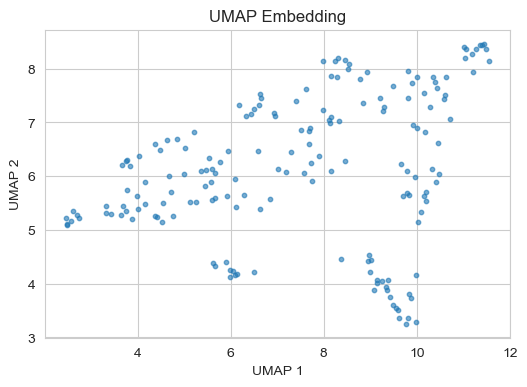

In [93]:
plt.figure(figsize=(6, 4))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6)
plt.title("UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

## Unsupervised Clustering

### Fit models

In [94]:
# HDBSCAN
cluster_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = cluster_hdb.fit_predict(X_umap)

# DBSCAN
clusterer_db = DBSCAN(eps=0.5, min_samples=5)
labels_db = clusterer_db.fit_predict(X_umap)

# K-Means
kmeans = KMeans(n_clusters=7, random_state=42)
labels_km = kmeans.fit_predict(X_umap)

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_umap)

Result collection

In [95]:
labels_dict = {
    "HDBSCAN": labels_hdb,
    #"DBSCAN": labels_db,
    "K-Means": labels_km,
    #"GMM": labels_gmm
}

In [96]:
labels_df = pd.DataFrame({
    'ID': df_merged['ID'],
    'Group': df_merged['Group'],
    'CDR_SB': df_merged['CDR_SB'],
    'MMSE': df_merged['MMSE'],
    'labels_gmm_cdr': df_merged['labels_gmm_cdr'],
    'HDBSCAN': labels_hdb,
    'DBSCAN': labels_db,
    'KMeans': labels_km,
    'GMM': labels_gmm
})

#labels_df.to_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/utils/clustering_labels_by_ID.csv", index=False)

In [97]:
# HDBSCAN optimal clusters
labels_hdb, n_hdb = evaluate_hdbscan(X_umap, min_cluster_size=5)

HDBSCAN found 11 clusters (excluding noise)



### Optimal number of clusters

In [98]:
# K-Means optimal clusters
#inertias, sil_scores = evaluate_kmeans(X_umap,K_range=range(2, 11),save_path=None,prefix= "gm",plot_flag=True)

# GMM optimal clusters
#aic, bic = evaluate_gmm(X_umap, K_range=range(2, 11), save_path=None, prefix="gm",plot_flag=True)

# Consenus clustering
#stability_scores = evaluate_consensus(X_umap,K_range=range(2, 11),n_runs=100,save_path=None,prefix='gm',plot_flag=True)

### Plotting

In [99]:
def plot_clusters_vs_labels(x_umap, labels_dictionary, label_source_df, label_column, figsize=(16, 24), margin=5):
    n = len(labels_dictionary)
    n_cols = 2
    n_rows = n

    x_min, x_max = x_umap[:, 0].min() - margin, x_umap[:, 0].max() + margin
    y_min, y_max = x_umap[:, 1].min() - margin, x_umap[:, 1].max() + margin

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for i, (title, labels) in enumerate(labels_dictionary.items()):
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        plot_df = pd.DataFrame({
            'X1': x_umap[:, 0],
            'X2': x_umap[:, 1],
            'cluster': labels,
            'label': label_source_df[label_column].reset_index(drop=True)
        })

        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='cluster', palette='Set1', s=50, ax=ax_left, legend='full')
        ax_left.set_title(f'{title} - Clustering')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_xlabel("UMAP 1")
        ax_left.set_ylabel("UMAP 2")

        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='label', palette='Set2', s=50, ax=ax_right, legend='full')
        ax_right.set_title(f'{title} - {label_column}')
        ax_right.set_xlim(x_min, x_max)
        ax_right.set_ylim(y_min, y_max)
        ax_right.set_xlabel("UMAP 1")
        ax_right.set_ylabel("UMAP 2")

    plt.tight_layout()
    plt.show()

In [100]:
#plot_clusters_vs_labels(X_umap, labels_dict, df_merged, label_column='labels_gmm_cdr', margin=1.5)

In [101]:
#plot_clusters_vs_labels(X_umap, labels_dict, df_merged, label_column='Group', margin=2.5)

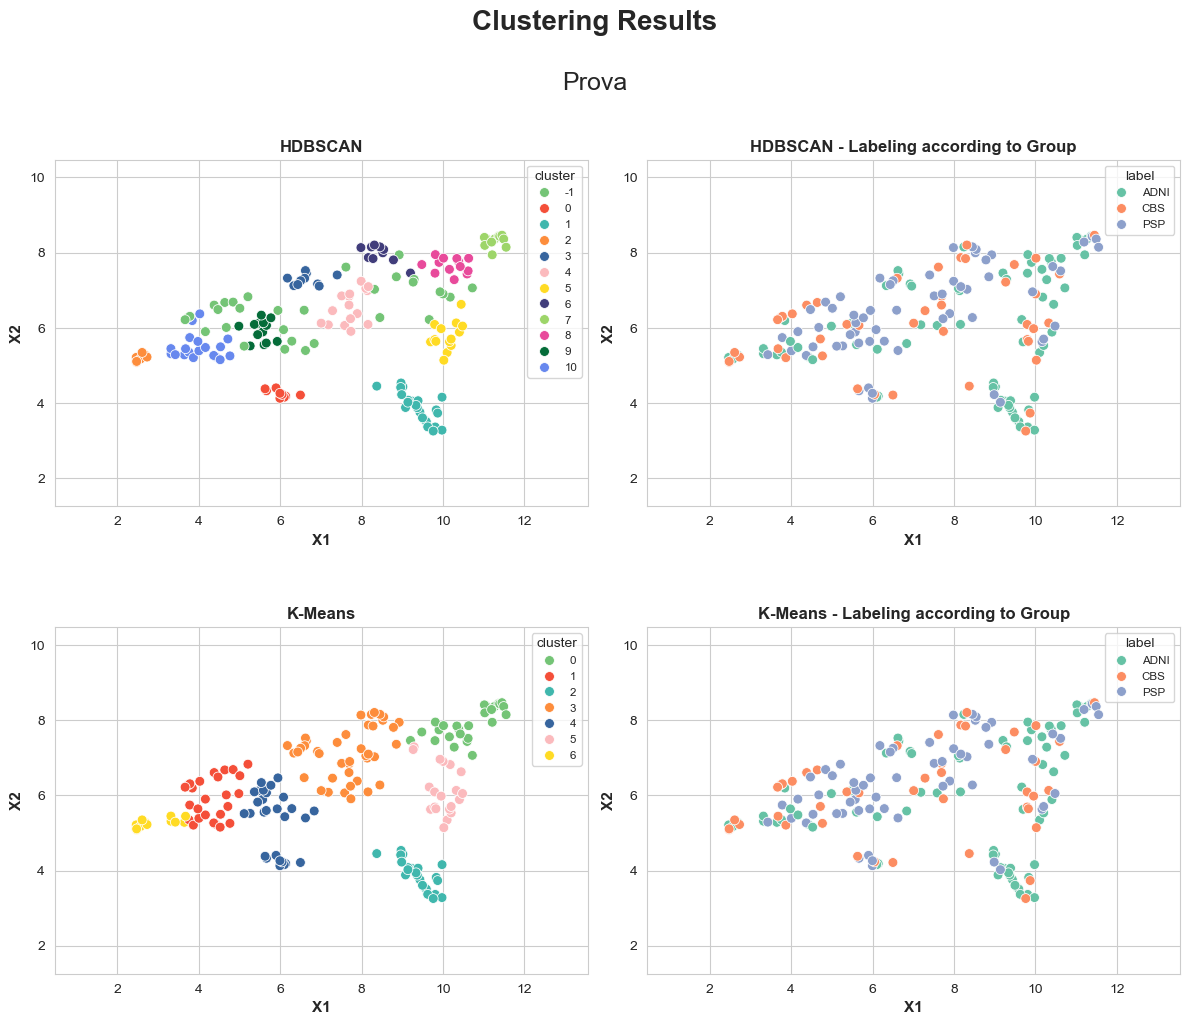

In [102]:
plot_clusters_vs_groups(X_umap, labels_dict, labels_df['Group'], save_path = None, title_prefix ='Prova', margin = 2.0, plot_flag=True)

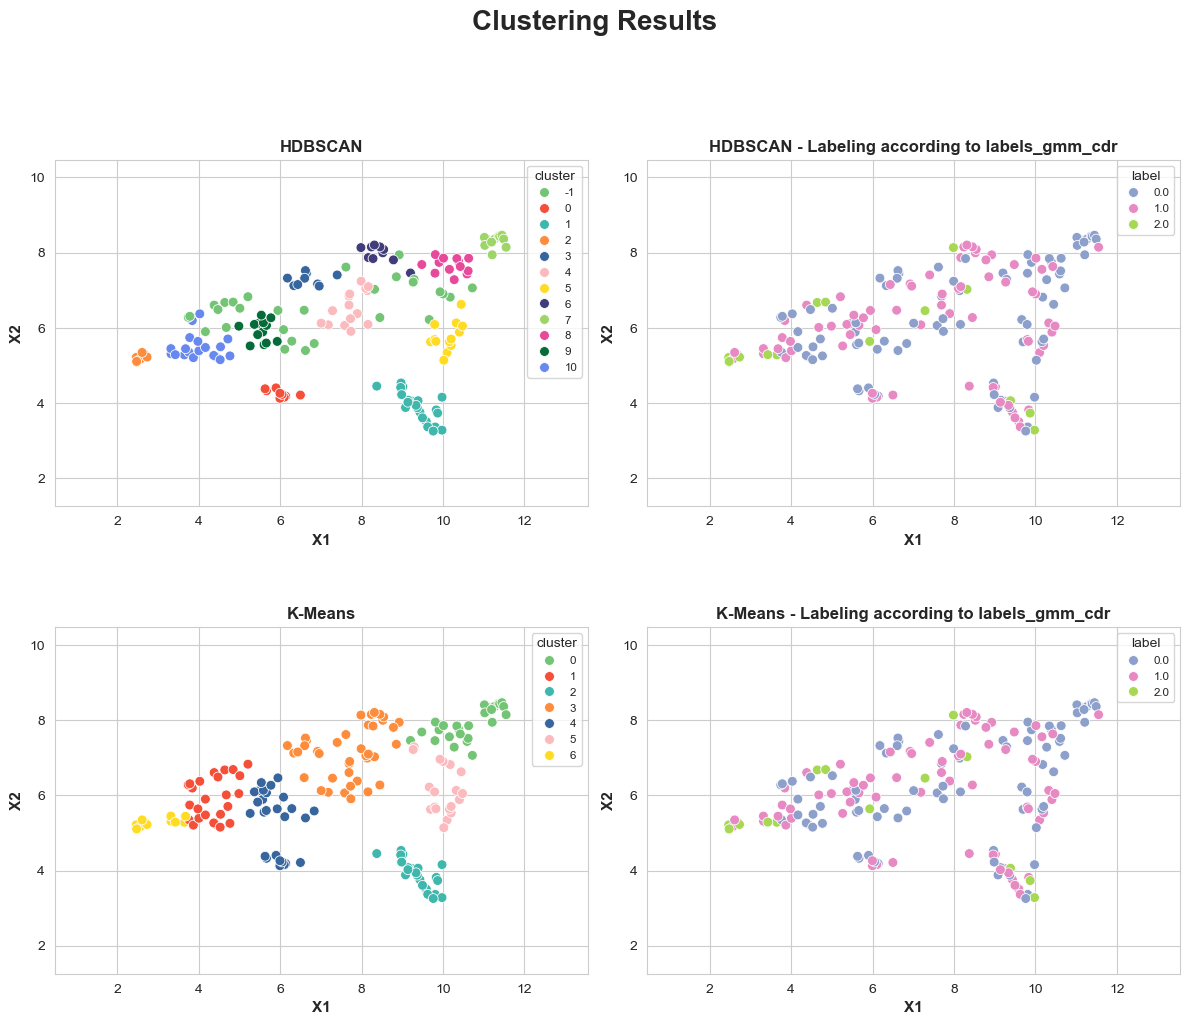

In [103]:
plot_clusters_vs_groups(X_umap, labels_dict, labels_df['labels_gmm_cdr'], save_path = None, title_prefix =None, margin= 2.0, plot_flag=True, colors_gmm= True)

### Statistical Evaluation

##### Do clusters separate diagnoses?

In [ ]:
diagnoses = ['ADNI', 'CBS', 'PSP']

for diag in diagnoses:
    print(f"\n=== Chi-squared test for {diag} ===")

    # Crea colonna binaria con etichette leggibili
    labels_df[f'{diag}_label'] = labels_df['Group'].apply(lambda x: diag if x == diag else 'other')

    # Tabella di contingenza: Cluster vs (diag vs other)
    contingency = pd.crosstab(labels_df['KMeans'], labels_df[f'{diag}_label'])
    print("Contingency Table:")
    print(contingency)

    # Chi-squared test
    chi2, p_value, dof, expected = chi2_contingency(contingency)

    # Output
    print(f"\nChi² = {chi2:.4f}")
    print(f"p-value = {p_value:.4f}")
    print(f"Degrees of Freedom = {dof}")

## Linear Regression
- Select dataframe and target variable
- OLS
- Plot
- Shuffling

### Data

In [104]:
# Load data
df_gm, df_meta = open_dataframes(path_df_gm, path_df_meta)

# Remove subjects with NaN values
target_col = "CDR_SB"
df_gm_regr = remove_missing_values(df_gm, df_meta, target_col)

# Features
df_merged, X = features_merging(df_gm_regr, df_meta)

# Print shapes
print("Old shape of the dataframe (data + ID): ", df_gm.shape)
print("New shape of the dataframe (data + ID): ", df_gm_regr.shape)
print("Shape of the complete dataframe (data + ID + metadata): ", df_merged.shape)
print("Shape of the metadata (ID included): ", df_meta.shape)
print("Shape of the input data X: ", X.shape)

Old shape of the dataframe (data + ID):  (176, 161818)
New shape of the dataframe (data + ID):  (171, 161818)
Shape of the complete dataframe (data + ID + metadata):  (171, 161829)
Shape of the metadata (ID included):  (176, 12)
Shape of the input data X:  (171, 161817)


### All subjects

In [108]:
# UMAP
reducer = umap.UMAP(**umap_params)
X_umap = reducer.fit_transform(X)

# Target
y = df_merged[target_col]

# Add constant (intercept)
X_with_const = sm.add_constant(X_umap)

# Fit OLS
model = sm.OLS(y, X_with_const).fit()

# Predictions and residuals
y_pred = model.predict(X_with_const)
residuals = y - y_pred

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     7.707
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           0.000628
Time:                        13:40:57   Log-Likelihood:                -445.84
No. Observations:                 171   AIC:                             897.7
Df Residuals:                     168   BIC:                             907.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5135      1.161      7.332      0.0

#### Plotting

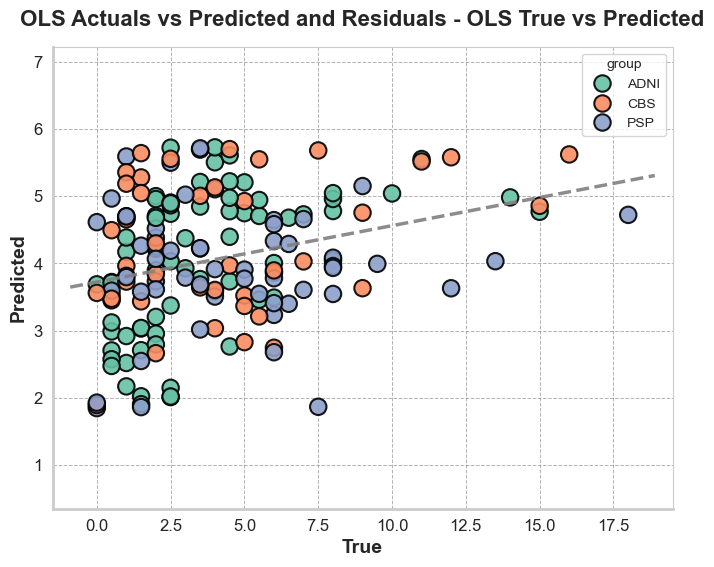

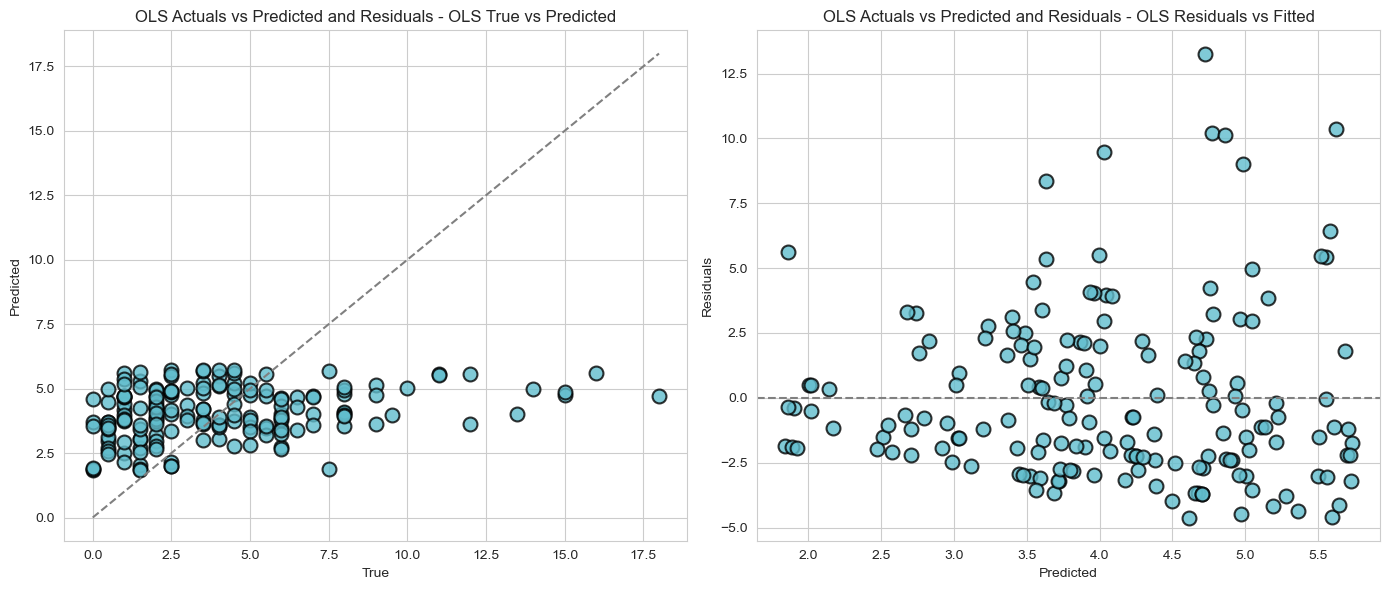

In [124]:
plot_ols_diagnostics(y, y_pred, residuals, "OLS Actuals vs Predicted and Residuals",save_path=None, plot_flag=True, color_by_group=True, group_labels=df_merged['Group'])

In [ ]:
#plot_actual_vs_predicted(target = y, predictions=  y_pred, "OLS Distributions", save_path=None, plot_flag=True):

#### Covariates

In [ ]:
# UMAP
reducer = umap.UMAP(**umap_params)
X_umap = reducer.fit_transform(X)

# Target
y = df_merged[target_col].astype(float)

# Covariate encoding
covariates = ["Sex", "Age", "Education"]
df_cov = df_merged[covariates].copy()

# Ensure numeric types
df_cov["Age"] = pd.to_numeric(df_cov["Age"], errors="coerce")
df_cov["Education"] = pd.to_numeric(df_cov["Education"], errors="coerce")
df_cov = pd.get_dummies(df_cov, drop_first=True)

# Combine UMAP + covariates
df_umap = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
X_design = pd.concat([df_umap.reset_index(drop=True), df_cov.reset_index(drop=True)], axis=1)

# Final casting
X_design = X_design.astype(float)

# Add constant
X_with_const = sm.add_constant(X_design)

# Fit OLS
model = sm.OLS(y, X_with_const).fit()

# Predictions and residuals
y_pred = model.predict(X_with_const)
residuals = y - y_pred

# Summary
print(model.summary())

#### Shuffling Regression

In [ ]:
# R² real
r2_real = model.rsquared

# List of R² after shuffling
r2_shuffled = []

for _ in range(100):
    y_shuffled = y.sample(frac=1, replace=False, random_state=None).reset_index(drop=True)
    model_shuffled = sm.OLS(y_shuffled, X_with_const).fit()
    r2_shuffled.append(model_shuffled.rsquared)

# empiric p-value
p_value = np.mean([r >= r2_real for r in r2_shuffled])

print(f"R² real: {r2_real:.4f}")
print(f"R² shuffled: {np.mean(r2_shuffled):.4f}")
print(f"p-value (shuffling): {p_value:.4f}")

### GMM distributions

In [239]:
# Load data
df_gm, df_meta = open_dataframes(path_df_gm, path_df_meta)

In [240]:
# CDR means
for gmmLabel in range(0,3):
    mean_cdr = df_meta.loc[df_meta['labels_gmm_cdr'] == gmmLabel, 'CDR_SB'].mean()
    print(f"Media CDR_SB per gruppo {gmmLabel}: {mean_cdr:.3f}")

Media CDR_SB per gruppo 0: 1.406
Media CDR_SB per gruppo 1: 5.243
Media CDR_SB per gruppo 2: 12.267


In [241]:
target_col = "CDR_SB"
label_col = "labels_gmm_cdr"

# Loop over each GMM cluster
for gmm_label in df_meta[label_col].dropna().unique():
    print(f"\n=== GMM Cluster {gmm_label} ===")

    # Get IDs for the current cluster
    ids_in_cluster = df_meta[df_meta[label_col] == gmm_label]["ID"]

    # Filter metadata and remove missing target values
    df_meta_cluster = df_meta[df_meta["ID"].isin(ids_in_cluster)].reset_index(drop=True)
    df_meta_cluster = df_meta_cluster[df_meta_cluster[target_col].notna()]

    # Filter voxel data accordingly
    df_cluster = df_gm[df_gm["ID"].isin(df_meta_cluster["ID"])].reset_index(drop=True)

    # Run regression
    model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
        df_masked = df_cluster,
        df_meta = df_meta_cluster,
        target_variable = target_col,
        covariates = ["Sex", "Age", "Education"],
        y_log_transform = False,
        plot_flag = False,
        save_path = None,
        title_prefix = f"gm_mask_GMM_{gmm_label}"
    )


=== GMM Cluster 0.0 ===
Dataframe shape after merge: (80, 161825)
Meta columns: 8
Feature matrix shape: (80, 161817) 

Running UMAP...

OLS REGRESSION SUMMARY
                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     1.965
Date:                Fri, 06 Jun 2025   Prob (F-statistic):             0.0938
Time:                        16:56:11   Log-Likelihood:                -87.715
No. Observations:                  80   AIC:                             187.4
Df Residuals:                      74   BIC:                             201.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

### Cluster K-Means

In [ ]:
# Load data
df_gm, df_meta = open_dataframes(path_df_gm, path_df_meta)

In [ ]:
target_col = "CDR_SB"
cluster_col = "KMeans"

for cluster_id in labels_df[cluster_col].unique():
    print(f"\n=== Cluster {cluster_id} ===")

    # Get subject IDs for the current cluster
    ids_in_cluster = labels_df[labels_df[cluster_col] == cluster_id]["ID"]

    # Filter df_meta and df_gm_masked based on IDs only
    df_meta_cluster = df_meta[df_meta["ID"].isin(ids_in_cluster)].reset_index(drop=True)
    df_cluster = df_gm[df_gm["ID"].isin(ids_in_cluster)].reset_index(drop=True)

    # Run regression (NaN removal is handled internally)
    model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
        df_masked = df_cluster,
        df_meta = df_meta_cluster,
        target_variable = target_col,
        covariates = ['Sex', 'Age', 'Education'],
        y_log_transform = False,
        plot_flag = True,
        save_path = None,
        title_prefix = f"cluster_{cluster_col}_{cluster_id}"
    )